In [1]:
import numpy as np 
import pandas as pd

## Data Preprocessing and some Feature Engineering

The first thing we have to do is to read the dataset, do some transformations and ensure that everything is in working fine. 

Data Visualisations can be done after to find out certain key statistics and characteristics of the data

In [2]:
dtypes = {'Pclass':'category', 'Sex':'category', 'Age':np.float16,
         'SibSp': np.float16, 'Parch':np.float16, 'Embarked':'category'}
train = pd.read_csv('../Kaggle Titanic/titanic (1)/train.csv', dtype = dtypes)

The first thing that strikes out as interesting from just the Data Dictionary itself, the prevalence of the ticket number : is it really necessary? Why is there a need for ticket number if ticket numbers should be linked to the person?

With that, we investigate the reason why by checking for the duplicates

In [3]:
train[train.Ticket.duplicated()].sort_values(by = ['Ticket']).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0.0,0.0,110152,86.50,B79,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0.0,0.0,110152,86.50,B77,S
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1.0,1.0,110413,79.65,E67,S
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0.0,2.0,110413,79.65,E68,S
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0.0,0.0,110465,52.00,A14,S


It seems that the duplicate tickets are precisely when people have the same ticket number and are living in cabins close to each other. 

This is similar to instances where a person makes a purchase or booking request to book 2 rooms, all these 2 rooms will fall under 1 ticket. What this means is that people who have the same ticket number, if not siblings, would somehow be related to each other. 

This could possibly help to generate an additional feature for us

With this additional feature, we could also consider dropping the ticket feature, there might not be a value add to us.

The only other possible value add would be the ticket numbers with letters in front could have been purchased in the same time or from the same area

In [4]:
train.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

We should split the Name column to first names and last names.

What can we achieve out of this? We could perhaps find certain relationships between cabin allocation and lexicoghical sorting of names in the first name or the last name basis.

In [5]:
names = train.Name.str.split(r"[,|.]", 2,
                             expand = True).rename({0:'Last',
                                                    1:'Title',
                                                   2:'First'}, axis =1)
names['Title'] = names['Title'].str.strip()
names['First']= names['First'].str.strip()
train = pd.concat([train,names], axis = 1)
train.drop(['Name'],axis = 1, inplace = True)
del names

Furthermore, since there are definitely no duplicated passengerID, we can safely drop the passengerID column

In [6]:
train.drop(['PassengerId'], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    category
 3   Age       714 non-null    float16 
 4   SibSp     891 non-null    float16 
 5   Parch     891 non-null    float16 
 6   Ticket    891 non-null    object  
 7   Fare      891 non-null    float64 
 8   Cabin     204 non-null    object  
 9   Embarked  889 non-null    category
 10  Last      891 non-null    object  
 11  Title     891 non-null    object  
 12  First     891 non-null    object  
dtypes: category(3), float16(3), float64(1), int64(1), object(5)
memory usage: 57.0+ KB


It seems that the only columns with nulls are the age and the Cabin Columns

For the Cabin Column, there are way too many nulls to do any form of null replacement, instead, we can replace the null values with 'unkown'.

We can however, replace the null of the age columns using medians

In [7]:
train['Age'].fillna(train['Age'].median(), inplace = True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
train['Fare'].fillna(train['Fare'].median(), inplace = True)

We can define whether or not the person is onboard alone without friends or family from the following columns: `SibSp`, `Parch` and duplicated ticket numbers

In [8]:
duplicated_numbers = train[train.Ticket.duplicated()].Ticket.unique()
train['alone'] = np.where((np.isin(train.Ticket,duplicated_numbers))|(train.SibSp>0) |(train.Parch > 0) ,0,1)

In [9]:
discretized_age = pd.cut(train.Age,[0,3,12,18,28,38,48,58,68,80], 
                                       labels = ['Toddler','Child','Teen','18-28'
                                                ,'28-38','38-48','48-58',
                                                '58-68','68-80'],right = True).rename('discrete_age', inplace = True)
discretized_fares = pd.qcut(train.Fare,4, labels = ['q1','q2','q3','q4']).rename('discrete_fares')
train = pd.concat([train,discretized_age,discretized_fares], axis =1)
del discretized_age, discretized_fares

In [10]:
train['FamSize'] = train['SibSp'] + train['Parch'] + 1

Consider using the Title as a way to determine Social Status.

Based on Google Searches, we learn the following:

Mr, Mrs, Miss, Master, Ms, Mme, Mlle all have the same Social Status and do not represent any form of nobility

In [11]:
normal = ['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Mme', 'Mlle']
military = ['Col', 'Capt', 'Major']
nobility = ['Lady','Sir', 'Jonkheer','the Countess','Don']
job = ['Dr','Rev']
train['Title'] = np.where(np.isin(train.Title, normal), 'normal', train.Title)
train['Title'] = np.where(np.isin(train.Title,military), 'military', train.Title)
train['Title'] = np.where(np.isin(train.Title, nobility), 'nobility', train.Title)
train['Title'] = np.where(np.isin(train.Title,job), 'job_function', train.Title)

In [12]:
train['Title'] = train['Title'].astype('category')

## Data Visualisation

Now we will make use of Data Visualisation to figure if we can create any new features based on insights made from the visualisation.

In [16]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

### Proportion of Survivors by Class and By Age

In [17]:
figure = px.bar(x= train.groupby(['Pclass']).count().index, 
                     y = train.groupby(['Pclass'])['Survived'].mean(),
                color = train.groupby(['Pclass']).count().index,
               title = 'Proportion of People Surviving per Class')
figure.update_layout(xaxis_title = 'Class',
              yaxis_title = 'Proportion',
              title = dict(x=0.5))
figure.show()

In [18]:
fig = make_subplots(rows = 1, cols = 2, subplot_titles = ('Proportion of People Surviving by Class', 'Histogram of Survivors by Age'))
fig.add_trace(go.Bar(x= train.groupby(['Pclass']).count().index, 
                     y = train.groupby(['Pclass'])['Survived'].mean(),
                     marker = dict(color = ['coral','cornflowerblue', 'lightseagreen']),
                    width = 0.8), row = 1, col = 1)
fig.add_trace(go.Histogram(x = train.sort_values(by='Age')['Age']), row = 1 , col = 2)

Clearly it can be seen that people from first class are most likely to survive, and people from third class are the least likely to survive.

It seems that the largest proportion of people that survive are the people aged 20-40. **However, this may not cut it. What this means is that having the count of number of people that survived per group of people is not a good metric**. Instead of that, we should be looking at the following:

We should be looking at proportion of people who survived per age group. this is a more accurate measure


In [19]:
binned = train.groupby(['discrete_age'])['Survived'].mean().reset_index()
fig = px.bar(x=binned.discrete_age,y = binned.Survived,
            title = 'Group vs. Survival Rate')
fig.update_layout(
    xaxis_title = 'Age Group',
    yaxis_title = 'Proportion Survived',
    title = dict(x=0.5))

From the above graph, it is clear that in fact most of the elderly, aged 65 and above have extremely low chance of surviving.
This could be due to the fact that the rescue efforts were concerned more with the able bodied people.

In fact, the highest survival rates are the especially young people from Toddler to teen, 

But the value changes once the teen becomes an adult. This is likely because once these children transition into becoming adults, each man is to fend for themselves, and in this case, the Class that they are in could actually play a part.

So to delve further into detail, we split the graph further into classes

In [20]:
binned2 = train.groupby(['discrete_age','Pclass'])['Survived'].mean().reset_index()
fig = px.bar(binned2, x= 'discrete_age',  y = 'Survived', color = 'Pclass', barmode = 'group',
      title = 'Proportion of Survivors by age group and class')
fig.update_layout(
    xaxis_title = 'Age Group',
    yaxis_title = 'Proportion Survived',
    title = dict(x=0.5))

It is clear that higher classes of people have a higher proportion of survival rate.

However, this value changes at the ages 58-68, it seems that the class does make a difference but only very marginal.

Furthermore, another interesting thing to note is the fact that Children in both first and second class all survived, but the survival rate for children in 3rd class have abysmal survival rates.

Strangely enough, toddlers in first class also do not have high survival rate. 

### Proportion of Survivors by Embarkation Location

In [21]:
px.bar(x=train.groupby(['Embarked'])['Survived'].agg(lambda x: x.sum()/x.count()).index,
      y= train.groupby(['Embarked'])['Survived'].agg(lambda x: x.sum()/x.count()),
      title = 'Proportion of Survivors by Embarked Location',
      labels = {'x':'Embarked Location', 'y': 'Proportion that Survived'})

It seems that the highest proportion of survivability is C followed by Q and S

It could indicate a relationship between Embarked Location and the type of people that come aboard(rich or not)

so the next thing we can consider is to investigate the relationship between the people who come aboard at various places with the Pclass

In [22]:
import seaborn as sns

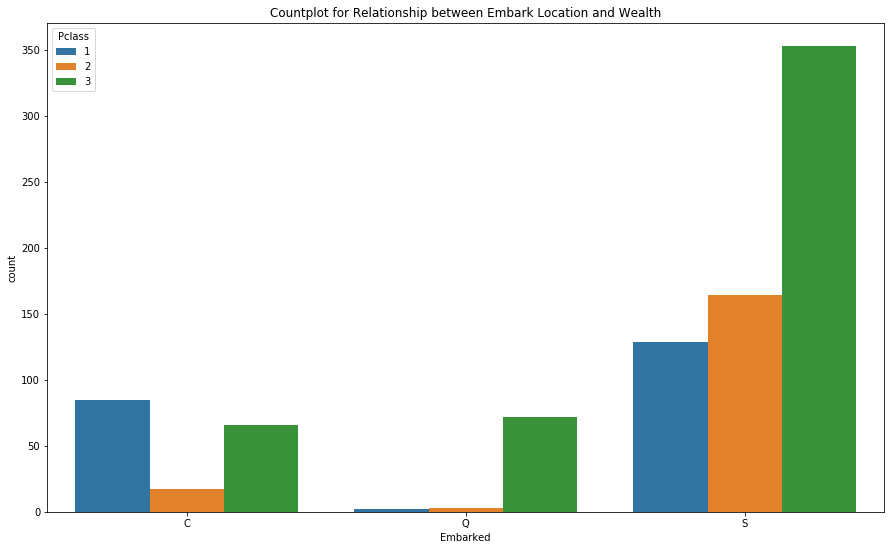

In [23]:
plt.figure(figsize = (15,9))
sns.countplot(x= 'Embarked', hue = 'Pclass', data = train)
plt.title('Countplot for Relationship between Embark Location and Wealth')
plt.show()

It seems that people embarking from Q are predominantly in 3rd Class, meaning that they are not as rich, and that people embarking from C are predominantly in 1st class. This means that the people embarking from C are the rich - this could indicate a neighbourhood or area that consists of more rich people.

Also, the largest proportion of people actually board at S. This could be the first embarkation point. hence, the most people due to the official launching

### Relationship between Ticket Fare and Class

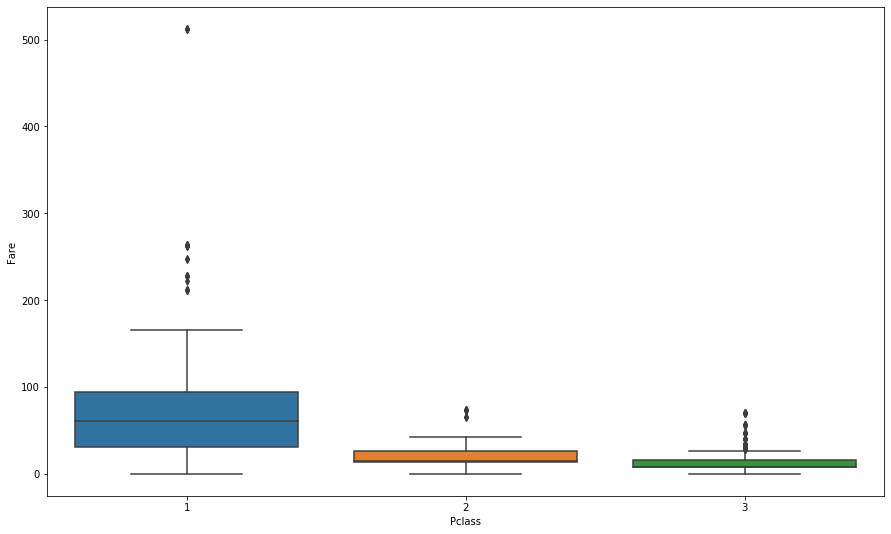

In [24]:
plt.figure(figsize = (15,9))
sns.boxplot(x='Pclass', y= 'Fare', data = train)
plt.show()

It is clear that higher fare costs implies higher Class, however, on interesting thing to note is that there some people may have gotten good deals and actually been able to get first class tickets at the price of second class tickets and similarly, some may have been able to get third class tickets at the median price first class tickets. 

This is slightly tragic as people with third class tickets have low survival rates eventually

### Checking whether or not being alone affects survivability

Instead of using just the simple way of doing this - That is, to make use of only the value of only survivability and being alone, we take into account the possibility of class as well. This is a better metric to understand what we are working with

We can consider building 2 different visualisations - one that considers the Class that they are in, and the second considering the age group that they are in.

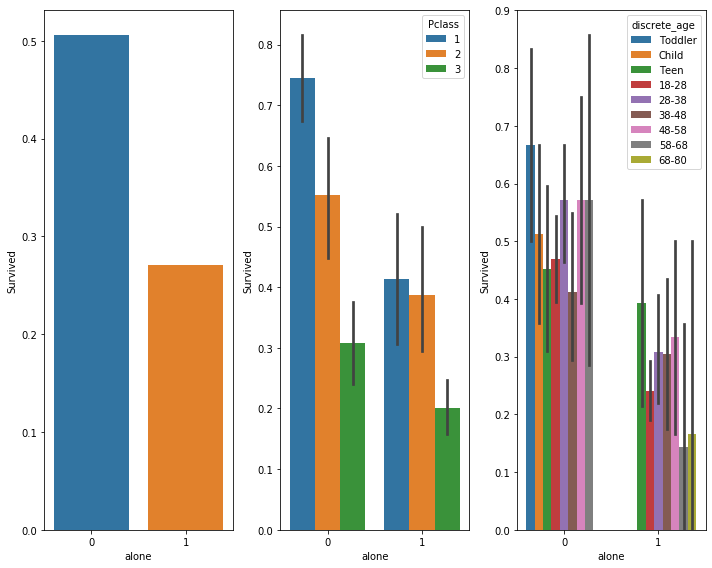

In [25]:
fig,axs = plt.subplots(1,3, figsize = (10,8))
sns.barplot(x = train.groupby('alone')['Survived'].mean().index, 
            y=train.groupby('alone')['Survived'].mean(), ax = axs[0])
sns.barplot(x = 'alone', y = 'Survived', hue = 'Pclass',
            data = train, ax = axs[1])
sns.barplot(x = 'alone', y= 'Survived', hue = 'discrete_age', data = train, ax = axs[2])
fig.tight_layout()
plt.show()

No toddlers are alone, as commmon sense would make. 

However, we learn some interesting information from these visualisation, 

It seems that across the board, across all categories and across all sub divisions, anyone who is not alone is more likely to survive than someone who is alone. Clearly, those in first class and those of younger ages are more likely to survive, whether alone or not, however, not being alone makes a lot of difference to their survival rate

There is absolutely no instance where being alone gives u an advantage of survival if comparing across the same subdivision, However, being in first class and second class and alone still gives u a better rate of survival than not being alone and in third class

### Comparing Gender and Survivability

C:\Users\Jerry\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



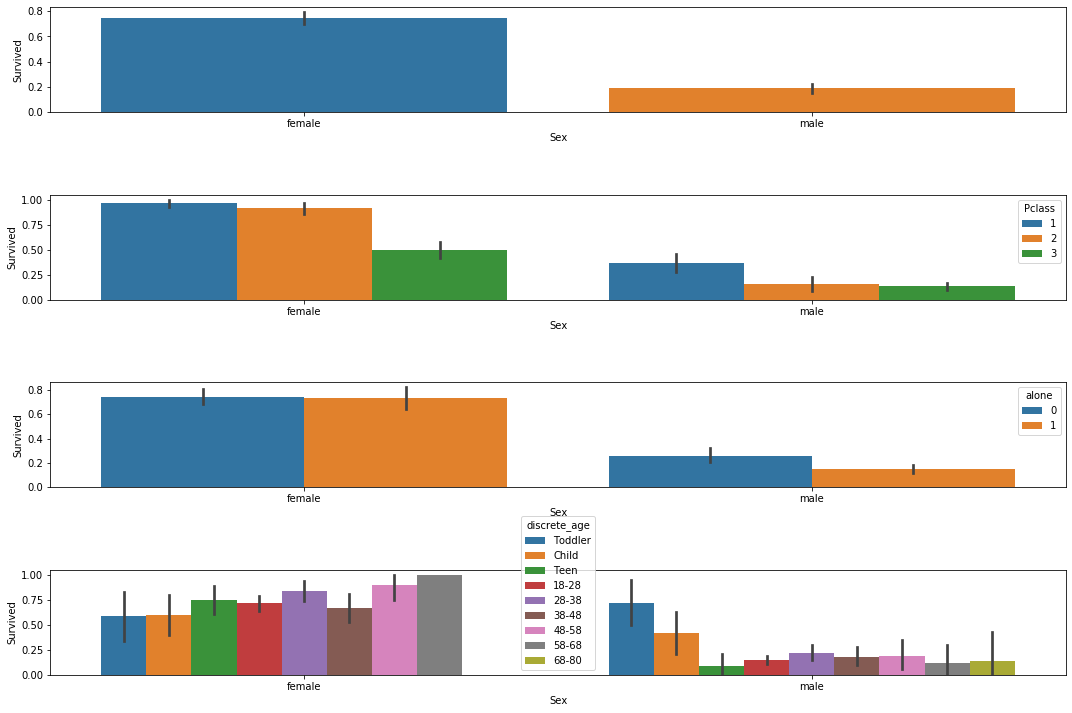

In [26]:
fig,axs2 = plt.subplots(4,1, figsize = (15,10))
sns.barplot(x= 'Sex', y= 'Survived',data = train, ax = axs2[0])
sns.barplot(x='Sex', y = 'Survived' , hue = 'Pclass', data = train, ax = axs2[1])
sns.barplot(x = 'Sex', y= 'Survived', hue = 'alone', data = train, ax = axs2[2])
sns.barplot(x = 'Sex', y = 'Survived', hue = 'discrete_age', 
            data =train, ax = axs2[3])
fig.tight_layout()
fig.show()

Clearly, it can be seen that there is a large disproportion between male and female survivability. In fact, we find that across all cases subdivisions apart from toddlers, females have better survivability rate as compared to males

### Considering Family Size vs Survival

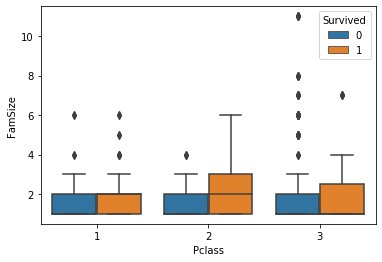

In [27]:
plt.Figure(figsize = (15,8))
sns.boxplot(x= 'Pclass', y = 'FamSize', hue = 'Survived',  data = train)
plt.show()

It seems that bigger family sizes actually have a higher possibility of survival

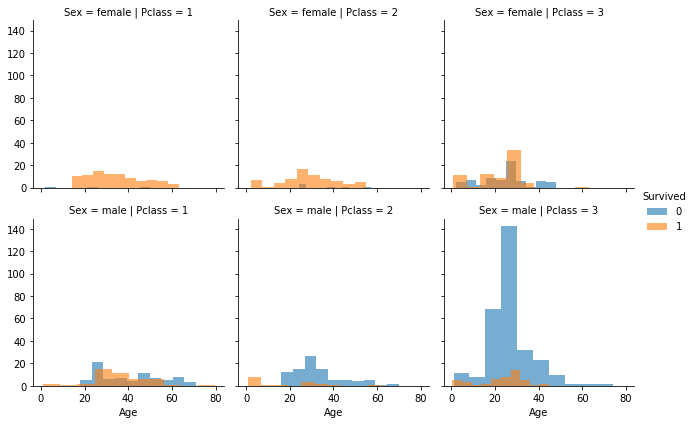

In [28]:
g = sns.FacetGrid(data = train, row = 'Sex', col = 'Pclass', hue = 'Survived')
g.map(plt.hist, 'Age', alpha = 0.6).add_legend()
plt.show()

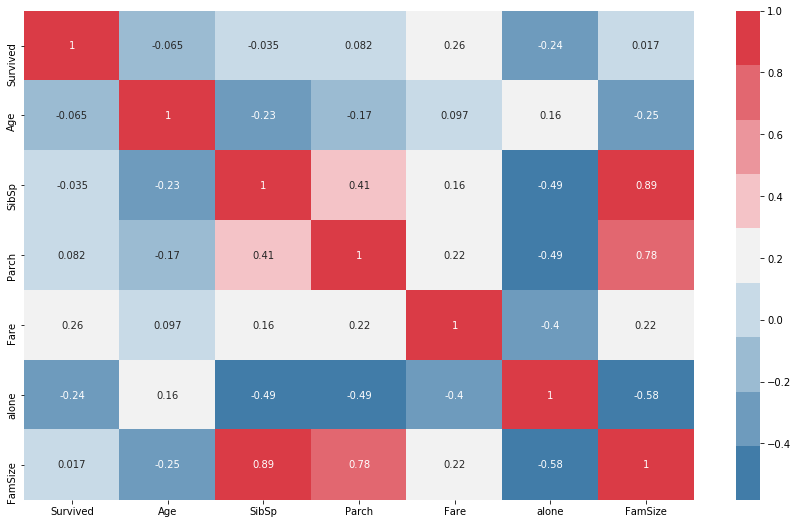

In [29]:
plt.figure(figsize = (15,9))
sns.heatmap(train.corr(), cmap = sns.diverging_palette(240, 10, n=9), annot = True)
plt.show()

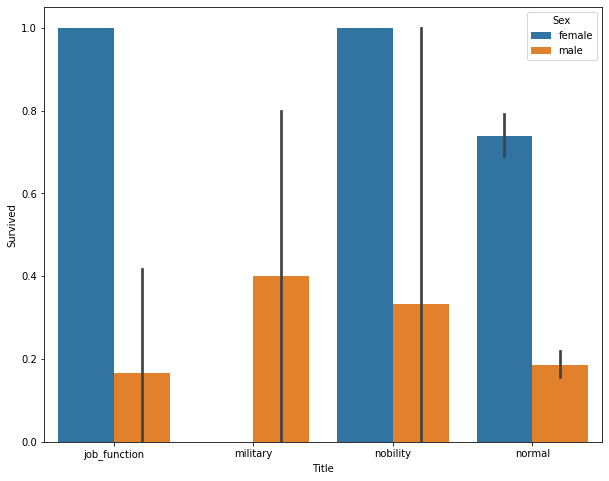

In [30]:
plt.figure(figsize = (10,8))
sns.barplot(data = train, x = 'Title', y = 'Survived', hue = 'Sex')
plt.show()

Interesting information gathered from this data, is the fact that military personnel are completely dominated by males - this is not surprising because of society back in the day.

However, it is interesting to note that despite people with statuses such as doctors and Reverends, it seems that typically, the 'normal' people actually have better survival rate as compared to doctors and likes of such. this could be due to the likely nature of their jobs - the morality of their jobs and code of conduct is typically one of servitude.

Finally, we can gather that the nobles have the highest survival rate

## Additional Cleaning and Splitting of Data

First off, we consider more processing of the dataset and split into training and test sets. This is for evaluation of model after cross validation


Clearly the `First`, `Ticket`, `Cabin` and quite possibly `Last` name does not matter in the classification, hence, we can consider dropping it

In [31]:
train.drop(['Cabin','Ticket','First','Last'], axis = 1, inplace = True)

In [32]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,alone,discrete_age,discrete_fares,FamSize
0,0,3,male,22.0,1.0,0.0,7.2500,S,normal,0,18-28,q1,2.0
1,1,1,female,38.0,1.0,0.0,71.2833,C,normal,0,28-38,q4,2.0
2,1,3,female,26.0,0.0,0.0,7.9250,S,normal,1,18-28,q2,1.0
3,1,1,female,35.0,1.0,0.0,53.1000,S,normal,0,28-38,q4,2.0
4,0,3,male,35.0,0.0,0.0,8.0500,S,normal,1,28-38,q2,1.0


In [33]:
from sklearn.model_selection import train_test_split
X = train[train.columns.difference(['Survived'])]
y = train['Survived']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2,
                                                random_state = 42,
                                                shuffle = True)
X_train.reset_index(drop=True,inplace = True)
X_test.reset_index(drop=True,inplace = True)
y_train.reset_index(drop=True,inplace = True)
y_test.reset_index(drop=True,inplace = True)

### Possible Encoding - Target Encoding (CatBoost Encoding)

Target Encoding helps to reduce cardinality - particularly if we were to utilize data such as the Discrete Age. It seems that this feature would benefit greatly from Target Encoding, since the difference in survival may not be so obvious

In [37]:
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.target_encoder import TargetEncoder

In [38]:
cat_features = ['discrete_age']
cb_encoder  = CatBoostEncoder(cols = cat_features)
train_encode = cb_encoder.fit_transform(X_train,y_train)

In [39]:
train_encode.head()

,Age,Embarked,FamSize,Fare,Parch,Pclass,Sex,SibSp,Title,alone,discrete_age,discrete_fares
0,45.5,S,1.0,28.5000,0.0,1,male,0.0,normal,1,0.376404,q3
1,23.0,S,1.0,13.0000,0.0,2,male,0.0,normal,1,0.376404,q2
2,32.0,S,1.0,7.9250,0.0,3,male,0.0,normal,1,0.376404,q2
3,26.0,S,2.0,7.8542,0.0,3,male,1.0,normal,0,0.188202,q1
4,6.0,S,7.0,31.2750,2.0,3,female,4.0,normal,0,0.376404,q4


Notice that after doing target encoding, what happens in CatBoost Encoding is that features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of hte target over all the training data, however, it excludes the current target when calculating the mean target for a level to reduce the effect of outliers

CatBoost Encoding works well because it calculates target statistic for each sample using the target from the history

In [40]:
test_encode = cb_encoder.transform(X_test)

Since CatBoost Encoding does indeed introduce some form of data leakage, it may not be ideal to use this. This is merely an option to explore. (and to show how CatBoost Encoding can be applied). However, in this case, it **might not be necessary.**

This is because typically, this is used when there is high cardinality in the data, and particularly when there are high dimensions within the dataset with few to little training data. This is not the case in this Titanic dataset. Dimensions are still fairly small, so One Hot Encoding can still work decently well in our case

#### Now that we have a training data set and a test dataset (or in this case a form of validation data set to check for validatity of our (validated) model, we can start building the model)

## Model Building

In this case, we consider using the model LightGradientBoostingModel since the algorithm has methods to work with categorical features

In [41]:
from lightgbm import LGBMClassifier as LGBC
from xgboost import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNC
np.random.seed(42)


First off, we create a basic lgb model to determine how well a base lgb model will perform

Remember that our training set consists of 

`X_train` and `y_train`

while the test dataset consists of `X_test` and `y_test`

### Light Gradient Boosting Model Training

We make our lives easier by creating multiple models by calling a class. We shall name this class model_building and within this model so that it is easier to build our various models without typing the same thing over and over again

In [48]:
class model_building(object):
    def __init__(self, clf,params = None):
        self.clf = clf(**params)
        
    @staticmethod
    def preprocessing(x_train,x_test):
        '''
        All models except LGB needs to undergo additional data preprocessing as they are unable to handle 
        categorical features
        
        
        returns processed data to be used after
        '''
        #creates list of categorical columns to one hot encode
        categorical = []
        train_x = x_train.copy()
        for columns in train_x.columns:
            if train_x[columns].dtype.name == 'category':
                categorical.append(columns)
        #fit the encoder         
        OHE = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
        OHE.fit(train_x[categorical])
        
        #create the encoded columns
        ohe_trans = OHE.transform(train_x[categorical])
        col= OHE.get_feature_names(categorical)
        
        #creates dictionary to create new dataframe for concatenation
        extra = dict(zip(col,ohe_trans.T))
        del ohe_trans
        extra = pd.DataFrame(extra)
        train_x = pd.concat([train_x,extra],axis = 1)
        del extra
        
        #drops original columns that were not necessary
        
        train_x.drop(categorical,axis =1 ,inplace = True)
        
        test_x = x_test.copy()
        
        #do the same for test data
        test_x_ohe = OHE.transform(test_x[categorical])
        extra_test = dict(zip(col,test_x_ohe.T))
        del test_x_ohe
        extra_test = pd.DataFrame(extra_test)
        test_x = pd.concat([test_x,extra_test],axis = 1)
        del extra_test
        
        test_x.drop(categorical,axis =1, inplace = True)
        
        return train_x,test_x

        
        
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
    
    def predict(self,x_test):
        return self.clf.predict(x_test)
    
    def feature_importances(self):
        '''
        can only be used after training the model.
        Do not use this prior to fitting the model
        '''
        return (self.clf.feature_importances_)
    
    @staticmethod
    def accuracy(pred,y_test):
        return accuracy_score(pred, y_test)
    

In [49]:
lgb_params = {
    'max_depth':3,
    'learning_rate': 0.15,
    'num_estimators' :500,
    'objective':'cross_entropy',
    'random_state':42
}
xgb_params = {
    'max_depth':3,
    'learning_rate': 0.1,
    'num_estimators': 500,
    'random_state':42,
    'objective':'binary:hinge'
}

In [50]:
lgb = model_building(LGBC, params = lgb_params)
lgb.train(X_train,y_train)
lgb_pred = lgb.predict(X_test)
lgb_acc = lgb.accuracy(lgb_pred,y_test)
print(lgb_acc)

0.8324022346368715


Straight out of the bag, it seems that the LGB model fares pretty well, however, this could likely be due to overfitting, especially since we used a Gradient Boosting model with high number of trees.

As we build this, we need to note that **particularly for tree-based methods AND boosting algorithms**, they are heavily influenced by cardinality. One Hot Encoding will typically result in worse results because the model will take a long time to build - it takes many levels to reach a point of classification

Clearly we should account for a better model through very careful subsampling and very careful gridsearch methods to make sure that our model performs well.  After all, our dataset is only the size of 712, it is very easy to overfit.

### XGBoost Model Training

Note that in this case, XGBoost does not have the capability to deal with categorical variables, hence, more is required from the Boosting Algorithm in the sense that one hot encoding needs to be applied. This is covered in the class `model_building` in which a static method  was introduced to process and create a OHE data

In [51]:
xgb = model_building(XGBC,params = xgb_params)
train_others,test_others = model_building.preprocessing(X_train,X_test)
xgb.train(train_others, y_train)
xgb_pred = xgb.predict(test_others)
xgb_acc = xgb.accuracy(xgb_pred,y_test)
print(xgb_acc)

0.8044692737430168


Similarly, the XGBoost model fares fairly well in this case as well, scoring an 80% accuracy rate out of the bag with little to no model tuning

### Logistic Regression Model Training

Next, we test with Logistic Regression

In [52]:
lr_params = {
    'C': 0.7,
    'max_iter':1000,
    'n_jobs': 8,
    'random_state':42
}

In [53]:
lr = model_building(LogisticRegression, lr_params)
lr.train(train_others,y_train)
lr_pred = lr.predict(test_others)
lr_acc = lr.accuracy(lr_pred,y_test)
print(lr_acc)

0.8100558659217877


### Random Forest Classification Model Training

In [54]:
rf_params = {
    'n_estimators': 800,
    'random_state':42,
    'n_jobs': 8,
    'bootstrap': True
}

In [55]:
rf = model_building(RFC,rf_params)
rf.train(train_others,y_train)
rf_pred = rf.predict(test_others)
rf_acc = rf.accuracy(rf_pred,y_test)
print(rf_acc)

0.8212290502793296


The Random Forest Classification model also fares well in this case. Because the number of trees used is fairly high, despite the idea of Random Forest, there could still be some form of Overfitting here in the sense that not enough subsampling is used,

However, right out of the bag. it seems to perform well

### Support Vector Machines

In [56]:
svc_params = {
    'C':1,
    'kernel': 'linear',
    'gamma':'auto',
    'random_state': 42
}

In [57]:
svc = model_building(SVC,svc_params)
svc.train(train_others,y_train)
svc_pred = svc.predict(test_others)
svc_acc = svc.accuracy(svc_pred,y_test)
print(svc_acc)

0.7821229050279329


### Gaussian Process Classifiers

In this model, we note that a kernel should be created for the sake of better classification. This is not done

In [58]:
gpc_params={
    'max_iter_predict': 10000,
    'random_state':42,
    'n_jobs':8
}

In [59]:
gpc = model_building(GPC,gpc_params)
gpc.train(train_others,y_train)
gpc_pred = gpc.predict(test_others)
gpc_acc = gpc.accuracy(gpc_pred,y_test)
print(gpc_acc)

0.7039106145251397


### AdaBoost Classifier

In [60]:
abc_params = {
    'n_estimators':1000,
    'learning_rate':0.7,
    'random_state':42,
    'algorithm': 'SAMME'
}

In [61]:
abc = model_building(ABC,abc_params)
abc.train(train_others,y_train)
abc_pred = abc.predict(test_others)
abc_acc = abc.accuracy(abc_pred,y_test)
print(abc_acc)

0.7988826815642458


### KNearestNeighbours Classifier

In [62]:
knc_params = {
    'n_neighbors': 5,
    'n_jobs': 8
}

In [63]:
knc = model_building(KNC, knc_params)
knc.train(train_others,y_train)
knc_pred = knc.predict(test_others)
knc_acc = knc.accuracy(knc_pred, y_test)
print(knc_acc)

0.7374301675977654


## LightGBM HyperParameter Tuning

Considering that the LightGBM model was the model that fared the best so far amongst all other models, we can consider using this to do a gridseach

In [65]:
from sklearn.model_selection import GridSearchCV

In [ ]:
light_params = {
    'n_estimators':[100,500,1000,1500,2000],
    'colsample_bytree':[0.7,0.8,1], #this samples the number of features being used to reduce overfit(variance)
    'subsample':[0.7,0.8,1], #this samples the total number of data in the dataset to reduce overfit
    'learning_rate':[0.01,0.05,0.1,0.5], #the smaller the learning rate, the more trees that are needed
    'max_depth': [1,3], #better to have smaller depth because it is a boosting algorithm and trains on the residuals of each iteration
    'objective': ['binary'],
    'reg_alpha': [0.1,0.5,0.8,1,1.5], #controls overfitting by introducing a regularizer
    'reg_lambda': [0.1,0.5,1,1.5], #this is an l2 regulariser   
    'bagging_freq': [0,1,2]
}
lgb = LGBC(random_state= 42, n_jobs = -1 )
grid = GridSearchCV(estimator = lgb,
                   param_grid = light_params,
                   cv=5,
                   n_jobs = 8,
                   refit = True, #ensures that the best model is returned
                   verbose = 1)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 21600 candidates, totalling 108000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 560 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 1560 tasks      | elapsed:   20.0s
[Parallel(n_jobs=8)]: Done 2624 tasks      | elapsed:   39.3s
[Parallel(n_jobs=8)]: Done 3168 tasks      | elapsed:   57.2s
[Parallel(n_jobs=8)]: Done 5368 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 6448 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 8808 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 11304 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 14672 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 17112 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 19528 tasks      | elapsed:  5.2min
[Parallel(n_jobs=8)]: Done 22474 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 26792 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 30296 tasks      | elapsed

`best_score_` returns the mean cross validated score of the best parameters

`best_params_` returns the best parameters that give the best solutions


With the best parameters, we will now use this to predict the data set to get a rough gauge of our out of sample performance

In [68]:
pred = grid.predict(X_test)
acc = accuracy_score(pred,y_test)
print('The Accuracy Rate is : ',acc)

The Accuracy Rate is :  0.8100558659217877


## Stacking Ensemble + Grid Search

Now that we have done some preliminary classification models to determine the effectiveness of our models, we can now consider using a few of these models to build a Stacking Ensemble and will apply GridSearch on this Ensemble to find the best solution to our problem

Import the relevant libraries

In [64]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import GridSearchCV

Here, we consider the following models as the base learners:

$\bullet$ LightGBM<br>
$\bullet$ SVC <br>
$\bullet$ RFC<br>
$\bullet$ LogisticRegression<br>

after which, with superior meta-features, we can consider utilizing Logistic Regression to do the final classification

In [81]:
np.linspace(100,1000,5)

array([ 100.,  325.,  550.,  775., 1000.])

In [91]:
clf1 = LGBC()
clf2 = SVC()
clf3 = RFC()
clf4 = LogisticRegression()
final = LogisticRegression()

sclf = StackingCVClassifier(classifiers = [clf1,clf2,clf3,clf4],
                           meta_classifier = final,
                           random_state =42,
                           cv = 3)

params = {
    'lgbmclassifier__colsample_bytree': [0.8],
    'lgbmclassifier__learning_rate': [0.05,0.1,0.15],
    'lgbmclassifier__max_depth': [3],
    'lgbmclassifier__n_estimators': [300,700],
    'lgbmclassifier__n_jobs': [8],
    'lgbmclassifier__objective':['binary'],
    'lgbmclassifier__subsample':[0.8],
    'lgbmclassifier__random_state': [42],
    'lgbmclassifier__reg_alpha': [0,0.5,1],
    'lgbmclassifier__reg_lambda': [0,0.5,1],
    'svc__C':np.logspace(-2,0.1,num=3),
    'svc__gamma': ['auto'],
    'svc__random_state': [42],
    'svc__kernel': ['linear'],
    'randomforestclassifier__bootstrap':[True],
    'randomforestclassifier__max_depth':np.linspace(100,1000,3),
    'randomforestclassifier__n_jobs': [8],
    'randomforestclassifier__random_state':[42],
    'logisticregression__C': np.logspace(-2,0.1,num=3),
    'logisticregression__max_iter': [1000],
    'logisticregression__random_state': [42],
    'meta_classifier__C':np.logspace(-2,0.1,num=3),
    'meta_classifier__random_state':[42],
    'meta_classifier__max_iter':[1000]   
}

In [ ]:
grid = GridSearchCV(estimator = sclf,
                   param_grid = params,
                   cv = 5,
                   refit=True,
                   verbose = 1,
                   n_jobs = 8)
grid.fit(train_others,y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
